# **CONNECT_4 GAME** #

First assignment for the Artificial Intelligence class, 2º Semester of 2º year. 

Game logic and interface implemented, as some search algorithms - A*, Monte Carlo.

Work developed by Lucas Oliveira, Marta Longo and Sara Táboas.

## **Libraries** ##

In [1]:
import numpy as np
from time import sleep
import contextlib
with contextlib.redirect_stdout(None):
    import pygame
    import pygame.gfxdraw
import time
import sys
import random
import copy

## **Game Logic** ##

**Attributes:**
- the attributes rows, cols, board(matrix of matrix) make the scructure of the board
- nullSymbol: represents the absence of pieces 
- p1Symbol and p2Symbol: represent the symbols of each player
- end: is True when the game is over
- winner: is True when someone winnes
- turn: represents the current player
- algorithm 1 and 2: is used when a player wants to play against a algorithm or algorithm vs algorithm


**Function __str__():**
- Generates a string representation of the game board, where each row is separated by a newline character and each column is represented by its corresponding symbol ('X', 'O', or '.').

**Function populateBoard():**
- Populates the game board with empty cells, represented by the null symbol ('.').
- Creates a 2D list representing the game board with the specified number of rows and columns.

**Function move(column, player):**
- A wrapper method for addToColumn().
- Invokes addToColumn() method to add a player's symbol to the specified column on the game board.

**Function addToColumn(column, player):**
- Adds a player's symbol to the specified column on the game board.
- Updates the game state, checks for a winner, and switches the player's turn.

**Function checkWinner(player, last_move):**
- Checks if the last move resulted in a win for the specified player.
- Examines the row, column, and diagonal(s) passing through the last move to determine if there are four consecutive symbols of the same player.

**Function showWinner(player):**
- Marks the game as ended and sets the winner if there is one.
- This method is called when a winning condition is detected.

**Function player(player):**
- Returns the corresponding player symbol ('X' or 'O') based on the player number (1 or 2).

**Function change_player():**
- Switches the turn between players.
- Updates the turn attribute to indicate whose turn it is next.

**Function possibleMoves():**
- Returns a list of possible moves (columns) where a player can make a move.
- Checks the top row of each column and returns the indices of columns with empty cells.

These functions collectively manage the game state, handle player moves, check for winning conditions, and provide information about possible moves.

In [2]:
class Board:
    def __init__(self):
        self.cols = 7
        self.rows = 6
        self.board = []
        self.nullSymbol = '.'
        self.p1Symbol = 'X'
        self.p2Symbol = 'O'
        self.populateBoard()
        self.end = False
        self.winner = None
        self.turn = 1
        self.algorithm1 = None 
        self.algorithm2 = None
        self.is_terminal = False
        
        
    def __str__(self):
        line = ""
        result = ""
        for i in range(self.rows-1, -1, -1):
            for ii in range(self.cols):
                line += self.board[i][ii]
            result += line + "\n"
            line = ""
        return result
    
    def copy(self):
        new_board = Board()
        new_board.board = [row[:] for row in self.board] 
        return new_board
    
    def evaluate_segment(self, segment):
        count_x = segment.count('X')
        count_o = segment.count('O')
        if count_o == 3 and count_x == 0:
            return -50
        elif count_o == 2 and count_x == 0:
            return -10
        elif count_o == 1 and count_x == 0:
            return -1
        elif count_x == 1 and count_o == 0:
            return 1
        elif count_x == 2 and count_o == 0:
            return 10
        elif count_x == 3 and count_o == 0:
            return 50
        elif count_x == 4:
            return 512
        elif count_o == 4:
            return -512
        else:
            return 0
        

    def heuristic(self, node):
        score = 0
        # Count occurrences of 'X' and 'O' in the node
        for i in range(self.rows):
            for j in range(self.cols):
                # Horizontal segments
                if j <= self.cols - 4:
                    segment = [node.board[i][j+k] for k in range(4)]
                    score += self.evaluate_segment(segment)
                # Vertical segments
                if i <= self.rows - 4:
                    segment = [node.board[i+k][j] for k in range(4)]
                    score += self.evaluate_segment(segment)
                # Diagonal segments (top-left to bottom-right)
                if i <= self.rows - 4 and j <= self.cols - 4:
                    segment = [node.board[i+k][j+k] for k in range(4)]
                    score += self.evaluate_segment(segment)
                # Diagonal segments (bottom-left to top-right)
                if i >= 3 and j <= self.cols - 4:
                    segment = [node.board[i-k][j+k] for k in range(4)]
                    score += self.evaluate_segment(segment)
        # Move bonus for player
        if self.turn == 1:
            score += 16
        elif self.turn == 2:
            score -= 16
        return score

    def populateBoard(self):
        aux = []
        for i in range(self.cols):
            aux.append(self.nullSymbol)
        for i in range(self.rows):
            self.board.append(aux.copy())

    def move(self, collumn, player):
        return self.addToCollumn(collumn, player)
        
            
    def addToCollumn(self, collumn, player):
        for i in range(len(self.board)):
            if self.board[i][collumn-1] == self.nullSymbol and self.possibleMoves().__contains__(collumn):
                self.board[i][collumn-1] = self.player(player)
                self.last_move = collumn
                if len(self.possibleMoves()) == 0:
                    self.end = True
                if self.checkWinner(self.player(player), (i,collumn-1)):
                    self.showWinner(self.player(player))   
                self.change_player() 
              
                return True
        return False
        
    def checkWinner(self, player, last_move):
        if len(self.possibleMoves()) == 0:
            self.end = True
        row, col = last_move
        token = player  # assuming player's token is represented by 'X' or 'O'

        # Check horizontal
        count = 0
        for c in range(self.cols):
            if self.board[row][c] == token:
                count += 1
                if count == 4:
                    return True
            else:
                count = 0

        # Check vertical
        count = 0
        for r in range(self.rows):
            if self.board[r][col] == token:
                count += 1
                if count == 4:
                    return True
            else:
                count = 0

        # Check diagonal up-left-to-right
        count = 0
        for i in range(-3, 4):
            if 0 <= row + i < self.rows and 0 <= col + i < self.cols:
                if self.board[row + i][col + i] == token:
                    count += 1
                    if count == 4:
                        return True
                else:
                    count = 0
        
        # Check diagonal down-left-to-right
        count = 0
        for i in range(-3, 4):
            if 0 <= row + i < self.rows and 0 <= col - i < self.cols:
                if self.board[row + i][col - i] == token:
                    count += 1
                    if count == 4:
                        return True
                else:
                    count = 0

        return False
                    
    def showWinner(self, player):
        self.end = True
        if self.winner == None:
            self.winner = player
            return self.winner

    def player(self, player):
        if player == 1:
            return self.p1Symbol
        elif player == 2:
            return self.p2Symbol
        
    def change_player(self):
        if self.turn == 1:
            self.turn = 2
        elif self.turn == 2:
            self.turn = 1 
        
        
    def possibleMoves(self):
        return [col+1 for col in range(self.cols) if self.board[self.rows-1][col] == self.nullSymbol]
    


## **Algorithms** ##

We have a class Node that adapts some of the algorithms we implemented.

**Atributes:**
- a value (a matrix of the board in AStarTree and a Board object in MonteCarloTree)
- a dictionary that represents the children of that same node {0: node0, 1: node1,...}




**(this last three are used for Monte Carlo)**
- a parent node which is a node too and represents the parent of the current node
- inicialized variable to count the number of wins (there a function to increment it)
- inicialized variable to count the number of visits (there a function to increment it)

**Functions:**
- We have setters and getters to make the operations easier
- genChildren function that generates the children nodes
- nodeHeight function that calls calculateNodeHeight and calculates the height of the node in the tree
- copy function that produces a copy of the current node 

In [3]:
class Node:
    def __init__(self, value, children, parent):
        self.value = value      # is a matrix of the board in AStarTree and is a Board object in MCTree
        self.children = children    # is a dictionary {0: node, 1: node, ...}
        self.parent = parent    # is another node
        self.wins = 0
        self.visits = 0
        
    def setValue(self, value):
        self.value = value
        
    def setChildren(self, children):
        self.children = children
        
    def getChild(self, child):
        return self.children[child]
        
    def setParent(self, parent):
        self.parent = parent
    
    def getParent(self):
        return self.parent
    
    def win(self):
        self.wins += 1
        
    def visit(self):
        self.visits += 1
        
    def genChildren(self, player):
        children = {}
        for i in self.value.possibleMoves():
            temporaryBoard = Board()
            temporaryBoard.board = np.copy(self.value.board)
            temporaryBoard.winner = self.value.winner
            temporaryBoard.end = self.value.end
            temporaryBoard.move(i, player)
            
            children[i] = Node(temporaryBoard, {}, self)
        self.setChildren(children)
    
    def nodeHeight(self):
        return self.calculateNodeHeight(self)

    def calculateNodeHeight(self, node):
        if node.parent == None: return 0
        else:
            return self.calculateNodeHeight(node.parent) + 1
        
    def copy(self):
        boardCopy = Board()
        boardCopy.board = np.copy(self.value.board)
        boardCopy.winner = self.value.winner
        boardCopy.end = self.value.end

        childrenCopy = {}
        for child in self.children:
            childrenCopy[child] = self.getChild(child).copy()
        
        node = Node(boardCopy, childrenCopy, self.parent)
        node.wins = self.wins
        node.visits = self.visits
        
        return node

**1. A-STAR ALGORITHM**

The first algorithm that we implemented was A*. This algorithm is an informed but non-adversarial strategy, therefore it does not take into account the fact that an adversary will change the state of the system in the next steps. The goal of this algorithm is to find the shortest path from a starting point to a goal point in a graph, considering the edge weights and a heuristic function. 

**Components**

**F(n) = G(n) + H(n)**

- F(n) = The total estimated cost of the cheapest path from the start node to the goal node that passes through node n
- G(n) = The cost of the path from starting node to node n
- H(n) = Estimated cost of the cheapest path from node n to the goal (heuristic function)
- The tree that is needed to generate nodes 

**A-Star Tree**

To generate the states of the board, we implemented a class that receives the board and player, where the root (object from Node class)is the inicial state and therefrom we generate the other states of the board using the genChildren function from the node class.

In [4]:
class AStarTree:
    def __init__(self, board, player):              # player is 1 or 2, board is a board object
        self.player = player                        # 1 or 2
        self.root = Node(board, {}, None)           # root node with the matrix of the board as its value
        self.root.genChildren(player)               # generates new children for the root

We chose to develop two heuristics:

- one that focuses on the evaluation of consecutive pieces (astar_h1.py)
- the one that was provided by the teacher (astar_h2.py)

However, we used the same functions to generate and select the best score nodes. Any object of the class AStarBot receives the current board and current player.

**Function play():**
- creates an object from the class AStarTree 
- generates the best move (a collumn) possible by calling function **bestMove(receives a tree)**
- then takes the best move and plays with it on the board

**Function bestMove(movesTree):**
- iterates on the root children and it runs through the function f
- the variable bestMove is a tuple where bestMove[0] = column; and bestMove[1] = f value or node score
- if bestMove is None, it sets bestMove to the current move being considered
- if the f value of the current move is lower than the f value of the current bestMove, it updates bestMove to the current move


**Function f(node)**
- sum of the heuristic function and the cost function


In [5]:
class Utils:
    def opponent(player):
        if player == 1:
            return 2
        elif player == 2:
            return 1
        
_inst = Utils
opponent = _inst.opponent

**Heuristic 1**

**Function h(node):**
- This function computes the heuristic value for a given node in the search tree
- It begins by extracting the current game board from the node.
- Then, it calculates the number of consecutive pieces for both the current player and the opponent in rows, columns, and diagonals.
- These counts are stored separately for the current player (selfConsecutives) and the opponent (opponentConsecutives).
- Finally, it computes the heuristic value by taking the difference between the opponent's and the current player's consecutive pieces in each category and applying a weight based on the number of sequences with that many pieces.
- The sum of these weighted differences represents the heuristic value for the node.

**Function checkRows(currentBoard, currentPlayer):**
- This function checks for consecutive pieces in rows on the game board.
- It iterates through each row and counts the consecutive pieces for the specified player (currentPlayer).
- If the sequence is interrupted by an opponent's piece or the end of the row, it records the count and resets it.
- The counts for sequences of length 1, 2, 3, and 4 or more are stored in a list and returned.

**Function checkCols(currentBoard, currentPlayer):**
- Similar to checkRows, this function checks for consecutive pieces in columns on the game board.
- It iterates through each column and counts the consecutive pieces for the specified player (currentPlayer).
- Again, it records the counts for sequences of different lengths and returns them.

**Function checkDiagonalsUpLeftToRight(currentBoard, currentPlayer):**
- This function checks for consecutive pieces in diagonals running from the upper left to the lower right.
- It iterates through the diagonals and counts the consecutive pieces for the specified player (currentPlayer).
- As with rows and columns, it records the counts for sequences of various lengths and returns them.

**Function checkDiagonalsDownLeftToRight(currentBoard, currentPlayer):**
- Similar to the previous function, this one checks for consecutive pieces in diagonals running from the lower left to the upper right.
- It iterates through the diagonals and counts the consecutive pieces for the specified player (currentPlayer), storing counts for different lengths of sequences.

In [6]:
class AStarBot_h1:
    def __init__(self, board, player):
        self.board = board      # board object
        self.player = player    # 1 or 2

    def play(self):
        movesTree = AStarTree(self.board, self.player)
        bestMove = self.bestMove(movesTree)
        self.board.move(bestMove, self.player)


    def bestMove(self, movesTree):   # movesTree is the tree of different moves, forbidenMoves is a list of positions to which it shouldn't make a move
        bestMove = None
        for move in movesTree.root.children:
            f = self.f(movesTree.root.getChild(move))
            g = self.g()
            h = self.h(movesTree.root.getChild(move))
            if bestMove == None:
                if movesTree.root.children.__contains__(4):
                    bestMove = (4, self.f(movesTree.root.getChild(4)))
                else:
                    bestMove = (move, f)
            if f < bestMove[1]:
                bestMove = (move, f)
        return bestMove[0]

    def f(self, node):
        return self.h(node) + self.g()

    def g(self):
        return 1

    def h(self, node):
        currentBoard = node.value.board
        selfConsecutives = []
        selfConsecutives.append(self.checkRows(currentBoard, self.player))
        selfConsecutives.append(self.checkCols(currentBoard, self.player))
        selfConsecutives.append(self.checkDiagonalsUpLeftToRight(currentBoard, self.player))
        selfConsecutives.append(self.checkDiagonalsDownLeftToRight(currentBoard, self.player))
        opponentConsecutives = []
        opponentConsecutives.append(self.checkRows(currentBoard, opponent(self.player)))
        opponentConsecutives.append(self.checkCols(currentBoard, opponent(self.player)))
        opponentConsecutives.append(self.checkDiagonalsUpLeftToRight(currentBoard, opponent(self.player)))
        opponentConsecutives.append(self.checkDiagonalsDownLeftToRight(currentBoard, opponent(self.player)))
        results = [0, 0, 0, 0]
        for i in range(len(selfConsecutives)):
            for ii in range(1, len(selfConsecutives)):
                results[ii] += ((ii+1)**(ii+1))*(opponentConsecutives[i][ii] - selfConsecutives[i][ii])     # multiplies the number of consecutive pieces by the number of sequences with that many pieces
        return sum(results)

    def checkRows(self, currentBoard, currentPlayer):
        consecutives = [0, 0, 0, 0]
        for i in range(4, 0, -1):
            inSequence = False
            counter = 0
            for r in range(len(currentBoard)):
                for c in range(len(currentBoard[0])):
                    if currentBoard[r][c] == self.board.player(currentPlayer):
                        counter += 1
                        inSequence = True
                    else:
                        if inSequence:
                            if currentBoard[r][c] != self.board.player(opponent(currentPlayer)):
                                if counter == i:
                                    consecutives[i-1] += 1
                        counter = 0
                        inSequence = False
                if inSequence:
                    if counter == i:
                        consecutives[i-1] += 1
                counter = 0
                inSequence = False
        return consecutives

    def checkCols(self, currentBoard, currentPlayer):
        consecutives = [0, 0, 0, 0]
        for i in range(4, 0, -1):
            for c in range(len(currentBoard[0])):
                inSequence = False
                counter = 0
                for r in range(len(currentBoard)):
                    if currentBoard[r][c] == self.board.player(currentPlayer):
                        counter += 1
                        inSequence = True
                    else:
                        if inSequence:
                            if currentBoard[r][c] != self.board.player(opponent(currentPlayer)):
                                if counter == i:
                                    consecutives[i-1] += 1
                        counter = 0
                        inSequence = False
                if inSequence:
                    if counter == i:
                        consecutives[i-1] += 1
                counter = 0
                inSequence = False
        return consecutives

    def checkDiagonalsUpLeftToRight(self, currentBoard, currentPlayer):
        consecutives = [0, 0, 0, 0]
        for i in range(4, 0, -1):
            inSequence = False
            counter = 0
            for r in range(len(currentBoard)):
                for s in range(len(currentBoard)):
                    if ((s+r > len(currentBoard) - 1 - r) or (s > len(currentBoard))):
                        break
                    if currentBoard[r+s][s] == self.board.player(currentPlayer):
                        counter += 1
                        inSequence = True
                    else:
                        if inSequence:
                            if currentBoard[r+s][s] != self.board.player(opponent(currentPlayer)):
                                if counter == i:
                                    consecutives[i-1] += 1
                        counter = 0
                        inSequence = False
                if inSequence:
                    if counter == i:
                        consecutives[i-1] += 1
                counter = 0
                inSequence = False
            inSequence = False
            counter = 0
            for r in range(len(currentBoard)-1, -1, -1):
                for s in range(len(currentBoard)):
                    aux = len(currentBoard)-r+s
                    if((s > r) or (aux > len(currentBoard))):
                        break
                    if currentBoard[s][aux] == self.board.player(currentPlayer):
                        counter += 1
                        inSequence = True
                    else:
                        if inSequence:
                            if currentBoard[s][aux] != self.board.player(opponent(currentPlayer)):
                                if counter == i:
                                    consecutives[i-1] += 1
                        counter = 0
                        inSequence = False
                if inSequence:
                    if counter == i:
                        consecutives[i-1] += 1
                counter = 0
                inSequence = False
        return consecutives

    def checkDiagonalsDownLeftToRight(self, currentBoard, currentPlayer):
        consecutives = [0, 0, 0, 0]
        for i in range(4, 0, -1):
            inSequence = False
            counter = 0
            for r in range(len(currentBoard)):
                for s in range(r+1):
                    if currentBoard[s][r-s] == self.board.player(currentPlayer):
                        counter += 1
                        inSequence = True
                    else:
                        if inSequence:
                            if currentBoard[s][r-s] != self.board.player(opponent(currentPlayer)):
                                if counter == i:
                                    consecutives[i-1] += 1
                        counter = 0
                        inSequence = False
                if inSequence:
                    if counter == i:
                        consecutives[i-1] += 1
                counter = 0
                inSequence = False
            inSequence = False
            counter = 0
            for r in range(1, len(currentBoard)):
                for s in range(r, len(currentBoard)):
                    
                    aux = len(currentBoard)+1+r-s
                    if (aux > len(currentBoard)):
                        aux = len(currentBoard)
                    
                    if currentBoard[s][aux] == self.board.player(currentPlayer):
                        counter += 1
                        inSequence = True
                    else:
                        if inSequence:
                            if currentBoard[s][aux] != self.board.player(opponent(currentPlayer)):
                                if counter == i:
                                    consecutives[i-1] += 1
                        counter = 0
                        inSequence = False
                if inSequence:
                    if counter == i:
                        consecutives[i-1] += 1
                counter = 0
                inSequence = False
        return consecutives

This heuristic evaluates the game state by considering the number of consecutive pieces for both the current player and the opponent, in rows, columns, and diagonals.
It calculates the difference between the opponent's and the current player's consecutive pieces, weighted by the number of sequences with that many pieces.
For each type of sequence (rows, columns, and diagonals), the heuristic assigns a value based on the difference between the consecutive pieces of the current player and the opponent.


The more favorable the situation is for the current player (i.e., the more consecutive pieces they have compared to the opponent), the higher the heuristic value.


The final heuristic value is the sum of these weighted differences, reflecting the relative advantage of the current position for the AI player compared to the opponent.

**Heuristic 2**

**Function evaluate_segment(segment):**
- This function evaluates a segment of four consecutive positions on the game board
- It counts the occurrences of 'X' and 'O' in the segment
- Depending on the counts, it assigns a score to the segment. For example, if there are 3 'O's and no 'X's, it returns -50. Similarly, if there are 2 'O's and no 'X's, it returns -10, and so on
- The function returns the score of the segment

**Function h(node):**
- This function calculates the heuristic value for a given node in the search tree
- It initializes a score variable to 0
- Then, it iterates over each position on the game board and considers all possible segments of four consecutive positions: horizontal, vertical, and diagonal
- For each segment, it calculates the score using the evaluate_segment function and adds it to the total score. Additionally, it adds a move bonus depending on the player ('X' or 'O')
- Finally, it returns the total score as the heuristic value for the node

In [7]:
class AStarBot_h2:
    def __init__(self, board, player):
        self.board = board      # board object
        self.player = player    # 1 or 2

    def play(self):
        movesTree = AStarTree(self.board, self.player)
        bestMove = self.bestMove(movesTree)
        self.board.move(bestMove, self.player)

    def bestMove(self, movesTree):   # movesTree is the tree of different moves, forbidenMoves is a list of positions to which it shouldn't make a move
        bestMove = None
        for move in movesTree.root.children:
            f = self.f(movesTree.root.getChild(move))
            g = self.g()
            h = self.h(movesTree.root.getChild(move))
            if bestMove == None:
                if movesTree.root.children.__contains__(4):
                    bestMove = (4, self.f(movesTree.root.getChild(4)))
                else:
                    bestMove = (move, f)
            if f < bestMove[1]:
                bestMove = (move, f)
        return bestMove[0]

 
    def f(self, node):
        return self.h(node) + self.g()

    def g(self):
        return 1
    
    def evaluate_segment(self, segment):
        count_x = segment.count('X')
        count_o = segment.count('O')
        if count_o == 3 and count_x == 0:
            return -50
        elif count_o == 2 and count_x == 0:
            return -10
        elif count_o == 1 and count_x == 0:
            return -1
        elif count_x == 1 and count_o == 0:
            return 1
        elif count_x == 2 and count_o == 0:
            return 10
        elif count_x == 3 and count_o == 0:
            return 50
        elif count_x == 4:
            return 512
        elif count_o == 4:
            return -512
        else:
            return 0

    def h(self, node):
        score = 0
        # Count occurrences of 'X' and 'O' in the node
        for i in range(self.board.rows):
            for j in range(self.board.cols):        
                # Horizontal segments
                if j <= self.board.cols - 4:
                    segment = [node.value.board[i][j+k] for k in range(4)]
                    score += self.evaluate_segment(segment)
                    
                # Vertical segments
                if i <= self.board.rows - 4:
                    segment = [node.value.board[i+k][j] for k in range(4)]
                    score += self.evaluate_segment(segment)

                # Diagonal segments (top-left to bottom-right)
                if i <= self.board.rows - 4 and j <= self.board.cols - 4:
                    segment = [node.value.board[i+k][j+k] for k in range(4)]
                    score += self.evaluate_segment(segment)

                # Diagonal segments (bottom-left to top-right)
                if i >= 3 and j <= self.board.cols - 4:
                    segment = [node.value.board[i-k][j+k] for k in range(4)]
                    score += self.evaluate_segment(segment)
                    
        #Add move bonus
        if self.player == 'X':
            score += 16
        else:
              score -= 16
        return score

The second heuristic assigns scores to segments of four consecutive positions on the board based on the number and arrangement of 'X's and 'O's within them.
The scoring system is designed to reflect the strength of the segment for the player owning the majority of the positions within it. For instance, segments with more 'X's and fewer 'O's are scored higher for the 'X' player, and vice versa.
Additionally, there are special scores assigned for winning configurations, such as four consecutive 'X's resulting in a win for 'X', or four consecutive 'O's resulting in a win for 'O'.


The heuristic value for the entire game state is computed as the sum of scores for all segments, with additional bonuses given to the current player ('X' or 'O') to encourage favorable moves.


Essentially, this heuristic focuses on evaluating localized patterns of pieces on the board, providing a more detailed analysis of the current game state compared to the first heuristic.

**2. MONTE CARLO**

Secondly, we implemented Monte Carlo. Monte Carlo Tree Search is a heuristic search algorithm used in decision processes, particularly in games with large branching factors and uncertain outcomes. It's known for its effectiveness in making decisions in games.

- **Selection:**
The search begins at the root of the game tree. In each iteration, it selects the most promising node to explore further using the Upper Confidence Bound (UCB), which balances exploration (visiting less explored nodes) and exploitation (visiting nodes with high estimated value).

- **Expansion:**
Once a node is selected, the algorithm expands the tree by adding child nodes corresponding to possible moves from that state. These child nodes represent potential future states of the game.

- **Simulation (Rollout):**
The algorithm performs a simulation (also known as a rollout) from one of the newly expanded nodes. The outcome of the simulation is then used to evaluate the potential of the selected node.

- **Backpropagation:**
After the simulation is complete, the results are backpropagated up the tree. The statistics of visited nodes, such as the number of wins and total simulations, are updated accordingly. This allows the algorithm to dynamically adjust its evaluations of different moves based on their simulated outcomes.

- **Selection of Next Move:**
After a specified number of iterations or computational resources, the algorithm selects the move corresponding to the best-performing child node of the root. This move is often chosen based on statistical measures such as the visit count or average reward obtained during simulations.

**Monte Carlo Tree**

Firstly, we implemented a class named NodeMontecarlo and MCTree to generate a tree to run the Monte Carlo algorithm.

**Atributes:**
- a value (a matrix of the board in AStarTree and a Board object in MonteCarloTree)
- a dictionary that represents the children of that same node {0: node0, 1: node1,...}




**(this last three are used for Monte Carlo)**
- a parent node which is a node too and represents the parent of the current node
- inicialized variable to count the number of wins (there a function to increment it)
- inicialized variable to count the number of visits (there a function to increment it)

**Functions:**
- We have setters and getters to make the operations easier
- genChild function that generates a child nodes
- nodeHeight function that calls calculateNodeHeight and calculates the height of the node in the tree
- copy function that produces a copy of the current node 
- remove_pm function removes the possible plays already expanded

In [8]:
class NodeMontecarlo:
    def __init__(self, value, children, parent, column=None):
        self.value = value      # is a matrix of the board in AStarTree and is a Board object in MCTree
        self.children = children    # is a dictionary {0: node, 1: node, ...} 
        self.parent = parent    # is another node
        self.wins = 0
        self.visits = 0
        self.possibleMoves = value.possibleMoves() # list with columns in which is possible to drop a piece
        self.column = column
    
        
    def setValue(self, value):
        self.value = value
        
    def addChildren(self, column, child): 
        self.children[column] = child
    
    def setChildren(self, children2):
        self.children2 = children2
    
    def remove_pm(self, move): # remove column from possible moves' list
        self.possibleMoves.remove(move)

    
    def getChild(self, child):
        return self.children[child]
        
    def setParent(self, parent):
        self.parent = parent
    
    def getParent(self):
        return self.parent
    

    def win(self):
        self.wins += 1
        
    def visit(self):
        self.visits += 1
        
    def genChild(self, column, player): # generates 1 child
        
        temporaryBoard = Board()
        temporaryBoard.board = np.copy(self.value.board)
        temporaryBoard.winner = self.value.winner
        temporaryBoard.end = self.value.end
        temporaryBoard.move(column, player)
        node = NodeMontecarlo(temporaryBoard, {}, self, column)
        self.addChildren(column, node)

        return node
    
    
    def nodeHeight(self):
        return self.calculateNodeHeight(self)

    def calculateNodeHeight(self, node):
        if node.parent == None: return 0
        else:
            return self.calculateNodeHeight(node.parent) + 1
        
    def copy(self):
        boardCopy = Board()
        boardCopy.board = np.copy(self.value.board)
        boardCopy.winner = self.value.winner
        boardCopy.end = self.value.end

        childrenCopy = {}
        for child in self.children:
            childrenCopy[child] = self.getChild(child).copy()
        
     
        node = NodeMontecarlo(boardCopy, childrenCopy,  self.parent)
        node.wins = self.wins
        node.visits = self.visits
        
        return node
   

**Attributes:**
- player: An attribute indicating the player for whom the tree is being constructed (player 1 or player 2).
- root: The root node of the tree, initialized with the initial game board and no children. 
- Each node in the tree represents a possible state of the game, and the root node represents the current state.

**Function __str__():**
- It generates a string representation of the tree by iterating through the children of the root node. For each child, it displays the node's statistics (number of wins and visits) and the winner of the corresponding game state.

In [9]:
class MCTree():
    def __init__(self, board, player):
        self.player = player                          # 1 or 2
        self.root = NodeMontecarlo(board, {}, None)   # root node with the board object as its value
        
    def __str__(self):
        result = ''
        for child in self.root.children:
            result += str(child) + ": " + str(self.root.getChild(child).wins) + "/" + str(self.root.getChild(child).visits) + " Winner: " + str(self.root.getChild(child).value.winner) + "\n"
        return result

Then we implemented a class named Monte Carlo to play the game.

**Attributes:**
- tree: This attribute holds an instance of the MCTree class, which represents the search tree used in the Monte Carlo Tree Search (MCTS) algorithm. The search tree organizes possible game states and their statistical information, facilitating efficient decision-making.
- player: This attribute indicates the player for whom the Monte Carlo Tree Search is being conducted. It helps in determining the perspective from which the search tree is explored and evaluated.
- state: The state attribute represents the current state of the game. It holds a board object that encapsulates the current configuration of the game board, including the positions of game pieces and the game's state (e.g., ongoing, won, or drawn).
- simulations: This attribute specifies the number of simulations (rollouts) to perform during each iteration of the Monte Carlo Tree Search algorithm. More simulations generally lead to more accurate evaluations but also increase computational overhead.
- c: The c attribute is a parameter used in the UCB1 formula, which balances exploration and exploitation during node selection in the search tree. Adjusting this parameter can affect the trade-off between exploring new branches of the tree and exploiting already visited branches.



**Functions:**


**Function selection():**

- This method selects the most promising node in the search tree based on the UCB1 formula.
- It recursively explores nodes until reaching a leaf node or a node with unvisited children, balancing exploration and exploitation.


**Function selecting(node):** 

- A helper method for selection(), selecting() recursively explores the tree to find the most promising node based on the UCB1 values of its children.


**Function bestMove(node):**

- Returns the child with best UCB1 between the node children. If there is more than one child with the best UCB1, the choice is made randomly.


**Function ucb1(node, move):** 

- Calculates the UCB1 value for a specific move of a node in the search tree. 
- The UCB1 value balances the exploitation of nodes with high win rates and the exploration of nodes with few visits.


**Function expansion(node):** 

- Chooses a random possible move of node and removes that play from the list possibleMoves (Node attribute).
- It generates the node child representing the move chosen randomly from the current game state and adds it to the tree


**Function simulation(node):** 

- Simulates a game rollout from a specific node until a terminal state is reached. It randomly selects moves until the game ends and returns whether the player wins from that specific node.


**Function backPropagation(node, won):** 

- Updates the visit and win counts of nodes in the path from a leaf node to the root node based on the outcome of the simulation. 
- It propagates the result of the simulation up to the tree to update the statistics of visited nodes.


**Function play():**

- The play() method executes the main loop of the Monte Carlo Tree Search algorithm. 
- It performs a specified number of simulations, updating the search tree based on the results, and then selects the best move found for the current game state.
- self.tree = tree.MCTree(self.state, self.player): This line initializes the MCTS tree with the current game state (self.state) and the current player (self.player).

- for _ in range(self.simulations): This line starts a loop that iterates self.simulations number of times. Each iteration of this loop represents one simulation step in the Monte Carlo Tree Search algorithm.

- node = self.selection(): This line selects a node from the tree using the selection method. 

- expanded_node = self.expansion(node): This line expands the selected node by adding a new child node to it. The expansion method selects a move from the possible moves at the selected node and creates a new child node corresponding to that move.

- if expanded_node.value.winner != self.def_player(self.player): This lines checks if the expanded_node winner hasn't yet been defined or if it is different from the current player.

- tempNode = expanded_node.copy(): This line creates a copy of the expanded node to perform a simulation without modifying the original game state.

- won = self.simulation(tempNode): This line simulates a game starting from the state represented by the copied node. It returns True if the simulation results in a win for the current player, otherwise False.

- self.backPropagation(expanded_node, won): This line backpropagates the result of the simulation from the expanded node up to the root node of the tree, updating visit counts and win counts along the way.

- self.state.move(best.column, self.player): This line updates the game state by making the best move selected in the previous steps. It modifies the game state to reflect the chosen move by the current player.

In [10]:
class MonteCarlo:
    def __init__(self, state, player):
        self.tree = MCTree(state, player)      # tree based on the board object
        self.player = player    # 1 or 2
        self.state = state  # Board object
        self.simulations = 10000
        self.p1Symbol = 'X'
        self.p2Symbol = 'O'
        self.c = 1/2
    
    def def_player(self, player):
        if player == 1:
            return self.p1Symbol
        elif player == 2:
            return self.p2Symbol
    
    def selection(self):
        return self.selecting(self.tree.root)
    
    def selecting(self, node):
        while not node.possibleMoves:
            result = self.bestMove(node)
            if result == None:
                return None
            node = result                
            
        return node

    
    def bestMove(self, node):
        
        if len(node.children) != 0:
            best = max(self.ucb1(node, move) for move in node.children)
        else:
            return None
        
        best_nodes = []
        for move in node.children:
            if self.ucb1(node, move) == best:
                best_nodes.append(node.children[move])
        return random.choice(best_nodes)
        
      
    def ucb1(self, node, move):
        ucb1 = float('inf')
        if not node.getChild(move).visits == 0 :
            exploitation = node.getChild(move).wins / node.getChild(move).visits
            exploration = np.sqrt(np.log(node.visits) / node.getChild(move).visits)
            ucb1 = exploitation + self.c * exploration
        return ucb1

    def expansion(self, node):
        column = random.choice(node.possibleMoves)
        node.remove_pm(column) # removes the play from possibleMoves' list
        if node.nodeHeight() % 2 == 0:
            new_node = node.genChild(column, self.player)
        else:
            new_node = node.genChild(column, opponent(self.player))
        return new_node


    def simulation(self, node):
        if len(node.value.possibleMoves()) == 0:
            return False
        turn = node.nodeHeight() % 2
        while not node.value.end:
            move = random.choice(node.value.possibleMoves())
            if (turn % 2) + 1 == 1:
                node.value.move(move, self.player)
            else:
                node.value.move(move, opponent(self.player))
            turn += 1
            if node.value.end:
                break
        if node.value.winner == self.def_player(self.player):
            return True
        else: return False

  
    def backPropagation(self, node, won):
        while node is not None:
            node.visit()
            if won:
                node.win()
            node = node.getParent()


        
        
    def play(self):
        self.tree = MCTree(self.state, self.player)      # tree based on the board object
        for _ in range(self.simulations):
            node = self.selection()
            
            if node == None:
                best = self.bestMove(self.tree.root)
                self.state.move(best.column, self.player)
                return
            
            expanded_node = self.expansion(node)
            
            if expanded_node.value.winner != self.def_player(self.player):
                tempNode = expanded_node.copy()
                won = self.simulation(tempNode) 
            else:
                won = True
            self.backPropagation(expanded_node, won)

        best = self.bestMove(self.tree.root)
        self.state.move(best.column, self.player)

**3. MINIMAX**

Another algorithm that we implemented was Minimax.

Minimax is a decision-making algorithm commonly used in game theory and artificial intelligence for making optimal decisions in adversarial settings. The goal of the algorithm is to choose the best possible move for the current player while assuming that the opponent will also make optimal moves.


The algorithm works by recursively exploring the game tree, which represents all possible moves and their outcomes. At each level of the tree, it alternates between maximizing the score (for the current player) and minimizing the score (for the opponent). This process continues until the game ends. At which point the algorithm evaluates the utility or score of that state.


Minimax assigns scores to each possible move based on the outcome of the game if that move is made. The score is typically determined using a heuristic evaluation function for non-terminal states, which estimates the likelihood of winning from that position.

**Attributes:**
- board: current state of the board
- player: current player



**Function play():**
- This method represents the bot's action during its turn. 
- It starts by creating a node representing the current state of the game board. 
- Then, it determines whether the bot is the maximizing player or not based on its assigned player number. 
- Next, it invokes the minimax() function to select the best move, considering a specified depth (here, 5 moves ahead). Finally, it makes the selected move on the game board and returns True.

**Function evaluate_segment(segment):**
- This method evaluates a segment of the game board (a sequence of adjacent cells) and assigns a score based on the configuration of X's and O's in that segment. 
- The score reflects how favorable the segment is for the bot.

**Function h(node):** 
- This heuristic evaluation function calculates a score for the current game state represented by the given node.
- It evaluates the entire game board by iterating over rows, columns, and diagonals, summing up scores for individual segments using the evaluate_segment function. 
- Additionally, it provides a move bonus based on whose turn it is.

**Function minimax(node, depth, maximizingPlayer):**
- This is the core Minimax algorithm implemented as a recursive function. 
- It explores the game tree up to a certain depth (depth) while considering whether it is maximizing the score for the bot (maximizingPlayer). 
- It generates children nodes representing possible future game states and recursively evaluates them, alternating between maximizing and minimizing player turns. 
- The function returns the column number and the associated score of the best move found.


In [11]:
class MinimaxBot:
    def __init__(self, board, player):
        self.board = board
        self.player = player
    

    
    def get_possible_moves(self, node, player):
        possible_moves = {}
        for col in range(node.cols):
            new_board = copy.deepcopy(node)
            if new_board.move(col + 1, player):
                possible_moves[col] = new_board
        return possible_moves
    

    
    def play(self):
        
        if self.player == 2:
            maximizingPlayer = True
        else:
            maximizingPlayer = False

        column, score = self.minimax(self.board, 5, maximizingPlayer)
        
        if column == None:
            column = self.board.possibleMoves[0]
        self.board.move(column + 1, self.board.turn)  # Adjust for 1-based indexing

        return True

    def minimax(self, node, depth, maximizingPlayer):

        if depth == 0 or self.board.is_terminal:
            return None, self.board.heuristic(node)

        if maximizingPlayer:
            maxEval = float('-inf')
            bestColumn = None
            oponent = 3 - self.board.turn
            possible_moves = self.get_possible_moves(node, oponent)
            
            if len(possible_moves) == 0: 
                self.board.is_terminal = True
            for i, child in possible_moves.items():
                _, value_current_board = self.minimax(child, depth - 1, False)
                if value_current_board > maxEval:
                    maxEval = value_current_board
                    bestColumn = i
            return bestColumn, maxEval
        
        else:  # Minimizing player
            minEval = float('inf')
            bestColumn = None
            oponent = 3 - self.board.turn
            possible_moves = self.get_possible_moves(node, self.board.turn)
            if len(possible_moves) == 0: 
                self.board.is_terminal = True
            for i, child in possible_moves.items():
                _, value_current_board = self.minimax(child, depth - 1, True)
                if value_current_board < minEval:
                    minEval = value_current_board
                    bestColumn = i
            return bestColumn, minEval

**4. ALPHABETA**

Alpha-Beta Pruning is an optimization technique used in decision trees, especially in game-playing algorithms like Minimax, to reduce the number of nodes that need to be evaluated. It works by eliminating branches of the tree that cannot possibly influence the final decision.

- Alpha: It represents the best (maximum) value that the maximizing player (maximizer) can guarantee at the current level or above.
- Beta: It represents the best (minimum) value that the minimizing player (minimizer) can guarantee at the current level or above.

- During the search:


    When the maximizing player (maximizer) finds a move with value greater than or equal to beta, it knows that the minimizing player (minimizer) won't choose this branch because the minimizing player can already achieve a value of beta or better elsewhere. So, it can prune this branch.
    Similarly, when the minimizing player (minimizer) finds a move with value less than or equal to alpha, it knows that the maximizing player (maximizer) won't choose this branch because the maximizing player can already achieve a value of alpha or better elsewhere. So, it can prune this branch.

- By pruning these branches, the search space is significantly reduced, allowing for a more efficient search for the optimal move.


In summary, Alpha-Beta Pruning efficiently prunes parts of the search tree that are guaranteed not to affect the final decision, leading to faster computation and more efficient game-playing algorithms.

**Function _init_:**
- This function initializes an instance of the AlphaBeta class.
- It takes a board object as a parameter and assigns it to self.board.

**Function get_possible_moves:**
- This function generates a dictionary of possible moves and their resulting board states for a given player.
- It takes two parameters: node (representing the current state of the game) and player (representing the player for whom possible moves are being generated).
- It iterates over each column in the game board and checks if making a move in that column for the specified player is valid.
- If the move is valid, it creates a new board state by deepcopying the current state (node), makes the move, and adds the resulting board state to the possible_moves dictionary.
- Finally, it returns the possible_moves dictionary.

**Function play:**
- This function orchestrates the playing process.
- It uses the minimax algorithm with alpha-beta pruning to find the best move for the current player (self.board.turn).
- It prints out the chosen move and its score.
- It updates the game board with the chosen move and returns True.

**Function minimax:**
- This function implements the minimax algorithm with alpha-beta pruning to evaluate potential moves and determine the best move for a player.
- It takes several parameters: node (representing the current state of the game), depth (the current depth of the search tree), alpha and beta (bounds for alpha-beta pruning), and maximizingPlayer (a boolean indicating whether the current node represents a maximizing or minimizing player).
- It recursively evaluates potential moves until reaching a terminal state or the specified depth limit.
- If it's the maximizing player's turn, it explores potential moves for the minimizing player and updates alpha with the maximum value found so far.
- If it's the minimizing player's turn, it explores potential moves for the maximizing player and updates beta with the minimum value found so far.
- It prunes branches of the game tree using alpha-beta bounds to improve efficiency.
- It returns the best move (column) and its corresponding score.

Overall, these functions work together to implement the Alpha-Beta Pruning algorithm for decision-making in games, efficiently searching through the game tree to find the best move for the current player while minimizing unnecessary evaluation

In [12]:
class AlphaBetaBot:
    def __init__(self, board, player):
        self.board = board
        self.player = player
    

    
    def get_possible_moves(self, node, player):
        possible_moves = {}
        for col in range(node.cols):
            new_board = copy.deepcopy(node)
            if new_board.move(col + 1, player):
                possible_moves[col] = new_board
        return possible_moves
    

    
    def play(self):
        if self.player == 2:
            maximizingPlayer = True
        else:
            maximizingPlayer = False
        
        column, score = self.minimax(self.board, 7, float('-inf'), float('inf'), maximizingPlayer)
        
        if column == None:
            column = self.board.possibleMoves[0]
        self.board.move(column + 1, self.board.turn)  # Adjust for 1-based indexing

        return True

    def minimax(self, node, depth, alpha, beta, maximizingPlayer):

        if depth == 0 or self.board.is_terminal:
            return None, self.board.heuristic(node)

        if maximizingPlayer:

            maxEval = float('-inf')
            bestColumn = None
            oponent = 3 - self.board.turn
            possible_moves = self.get_possible_moves(node, oponent)
            
            if len(possible_moves) == 0: 
                self.board.is_terminal = True
            for i, child in possible_moves.items():
                _, value_current_board = self.minimax(child, depth - 1, alpha, beta, False)
                if value_current_board > maxEval:
                    maxEval = value_current_board
                    bestColumn = i
                    alpha = max(alpha, maxEval)
                    if alpha >= beta:
                        break
            return bestColumn, maxEval
        
        else:  # Minimizing player
            minEval = float('inf')
            bestColumn = None
            oponent = 3 - self.board.turn
            possible_moves = self.get_possible_moves(node, self.board.turn)
            if len(possible_moves) == 0: 
                self.board.is_terminal = True
            for i, child in possible_moves.items():
                _, value_current_board = self.minimax(child, depth - 1, alpha, beta, True)
                if value_current_board < minEval:
                    minEval = value_current_board
                    bestColumn = i
                    beta = min(beta, minEval)
                    if alpha >= beta:
                        break
            return bestColumn, minEval

## **Game interface and Menu** ##

The interface for Connect Four uses the Pygame library for python to represent the game logic described above. It's based on a grid layout where players can drop their pieces. It uses two colors, red and blue, to identify the players and it respondes to mouse interaction. 

**Function main(game, algorithm1, algorithm2, GUI):**
- This is the main function that orchestrates the gameplay.
- It sets up the game with the specified AI algorithms and GUI mode. 
- If GUI mode is disabled, it initiates gameplay on the terminal; otherwise, it sets up gameplay on the GUI, allowing for human vs. AI or AI vs. AI gameplay depending on the presence of AI algorithms.



The menu uses the Pygame library for python to create a simple game menu with buttons for 2 players, player vs algorithm and algorithm vs algorithm. 

Developed with two classes, Button and Menu.


Class Button - creates the necessary buttons for the menu by drawing them on the screen and allowing them to respond to mouse interaction.

In [13]:
class Button:
    def __init__(self, text, width, height, font, text_color, backgroud_color, x_pos, y_pos):
        self.text = text
        self.width = width
        self.height = height
        self.font = font
        self.text_color = text_color
        self.background_color = backgroud_color
        self.x_pos = x_pos 
        self.y_pos = y_pos
        
        self.colors = {'black': (0, 0, 0),
                       'white': ( 255, 255, 255),
                       'yellow': (255, 255, 0),
                       'red': (255, 0, 0),
                       'camel': (230, 191, 131),
                       'brown': (193, 154, 107)}
        self.rect = pygame.Rect(x_pos, y_pos, width, height)


    def draw(self, screen):
        pygame.draw.rect(screen, self.background_color, (self.x_pos, self.y_pos, self.width, self.height))
        text_surface = self.font.render(self.text, True, self.colors['black'])
        text_rect = text_surface.get_rect(center=(self.x_pos + self.width / 2, self.y_pos + self.height / 2))

        screen.blit(text_surface, text_rect)


    def collide_point(self, pos):
        return self.rect.collidepoint(pos)

In [14]:
collumn_count = 7
row_count = 6
square_size = 100

# Set the dimensions of the screen
width = collumn_count * square_size 
height = (row_count + 1) * square_size


colors = {
    "BLUE": (0, 0, 255),
    "BLACK": (0, 0, 0),
    "RED": (255, 0, 0),
    "YELLOW": (255, 255, 0),
    "WHITE": (255, 255, 255),
    "BACKGROUND": (230, 191, 131),
    "GRILL": (193, 154, 107),
    "EMPTY": (230, 230, 230)
    }


def draw_hover_piece(screen, current_player, column, piece_surface):
    if current_player == 'X':
        color = colors["RED"]
    else:
        color = colors["BLUE"]

    center_x = (column * square_size) + (square_size // 2)
    center_y = square_size // 2

    piece_surface.fill((0, 0, 0, 0))
    pygame.gfxdraw.aacircle(piece_surface, square_size // 2, square_size // 2,
                            square_size // 2 - 5, color)
    pygame.gfxdraw.filled_circle(piece_surface, square_size // 2, square_size // 2,
                                 square_size // 2 - 5, color)

    screen.blit(piece_surface, (center_x - square_size // 2, center_y - square_size // 2))



def draw_board(game, screen):
    def draw_pieces():
        def draw(color):
            pygame.gfxdraw.aacircle(screen, c * square_size + square_size // 2,
                                    (game.rows - r) * square_size + square_size // 2,
                                    square_size // 2 - 5, color)
            pygame.gfxdraw.filled_circle(screen, c * square_size + square_size // 2,
                                         (game.rows - r) * square_size + square_size // 2,
                                         square_size // 2 - 5, color)

        for c in range(game.cols):
            for r in range (game.rows):
                draw(colors["WHITE"])
                if game.board[r][c] == 'X':
                    draw(colors["RED"])
                elif game.board[r][c] == 'O':
                    draw(colors["BLUE"])
                    
        
        

    if game.end:
       
        font = pygame.font.Font(None, 64)
        if game.winner == 'X':
            winner_text = font.render("Red wins!", True, colors["RED"])
        elif game.winner == 'O':
            winner_text = font.render("Blue wins!", True, colors["BLUE"])
        else:
            winner_text = font.render("It's a tie!", True, colors["BLACK"])
        text_rect = winner_text.get_rect(center=(width // 2, square_size // 2))
        screen.blit(winner_text, text_rect)

        draw_pieces()
        pygame.display.update()
        pygame.time.delay(4000)
        pygame.quit()
        exit()
    screen.fill(colors["BACKGROUND"])
    pygame.gfxdraw.box(screen, (0, 0, width, square_size), colors["WHITE"])
    draw_pieces()

def input_column():
    while True:
        column = input("Choose a column: ")
        if column.isdigit():
            column = int(column)
            if 1 <= column <= collumn_count:
                return column

def play_on_terminal(game, verbose=True):
    while True:
        if verbose:
            print(game)
            if game.end:
                if game.winner == 'X':
                    print("Red wins!")
                elif game.winner == 'O':
                    print("Blue wins!")
                else:
                    print("It's a tie!")
                break
            elif game.turn == 1:
                print("Blue's turn")
                if game.algorithm2 is None:
                    column = input_column()
                else:
                    column = algorithms_move(game, game.algorithm1)
                    sleep(0.5)
                if not game.move(column, game.turn):
                    print("Invalid move")
            else:
                print("Red's turn")
                if game.algorithm2 is None:
                    if game.algorithm1 is None:
                        column = input_column()
                    else:
                        column = algorithms_move(game, game.algorithm1)
                        sleep(0.5)
                else:
                    column = algorithms_move(game, game.algorithm2)
                    sleep(0.5)
                if not game.move(column, game.turn):
                    print("Invalid move")
                print()
        else:
            if not game.end:
                if game.turn == 2:
                    game.move(algorithms_move(game, game.algorithm1))
                else:
                    game.move(algorithms_move(game, game.algorithm2))

def play_game(game):
    
    pygame.init()
    clock = pygame.time.Clock()
    clock.tick(60)

    screen = pygame.display.set_mode((width, height))
    pygame.display.set_caption('Connect 4 - player vs ' + str(game.algorithm1))

    while not game.end:
        draw_board(game, screen)
        event = pygame.event.wait()
        if event.type == pygame.QUIT:
            exit()
        if event.type == pygame.MOUSEMOTION:
            draw_hover_piece(screen, game.player(game.turn), pygame.mouse.get_pos()[0] // square_size,
                             pygame.Surface((square_size, square_size), pygame.SRCALPHA))
        elif event.type == pygame.MOUSEBUTTONDOWN:
            pos = pygame.mouse.get_pos()
            column = pos[0] // square_size
            if game.move(column + 1, game.turn):
                if not game.end and game.algorithm1 is not None:
                    draw_board(game, screen)
                    pygame.display.update()
                    algorithms_move(game, game.algorithm1)
        pygame.display.update()
        
    draw_board(game, screen)
    

def algorithm_vs_algorithm(game):
    pygame.init()
    clock = pygame.time.Clock() 
    clock.tick(60)

    screen = pygame.display.set_mode((width, height))
    pygame.display.set_caption('Connect 4 - ' + str(game.algorithm1) + ' vs ' + str(game.algorithm2))

    draw_board(game, screen)
    pygame.display.update()
    
    while True:
        draw_board(game, screen)
        event = pygame.event.wait()
        if event.type == pygame.QUIT:
            pygame.quit()
            exit()
            
        # print(game.turn)
        if game.turn == 1:
            algorithms_move(game, game.algorithm1)
        elif game.turn == 2:
            algorithms_move(game, game.algorithm2)
        
        draw_board(game, screen)
        pygame.time.delay(100)
        pygame.display.update()


def algorithms_move(game_board, algorithm):
    if algorithm=="astar_h1":
        bot = AStarBot_h1(game_board, game_board.turn)
        bot.play()
    elif algorithm=="astar_h2":
        bot = AStarBot_h2(game_board, game_board.turn)
        bot.play()
    elif algorithm=="montecarlo":
        bot = MonteCarlo(game_board, game_board.turn)
        bot.play()
    elif algorithm=="minimax":
        bot = MinimaxBot(game_board, game_board.turn)
        bot.play()
    elif algorithm=="alphabeta":
        bot = AlphaBetaBot(game_board, game_board.turn)
        bot.play()
    elif algorithm == None:
        game_board.move(int(input()), game_board.turn)

def main(game, algorithm1, algorithm2, GUI):
    game.algorithm1 = algorithm1
    game.algorithm2 = algorithm2

    if not GUI:
        play_on_terminal(game)
    else:
        if game.algorithm1 is not None:
                if game.algorithm2 is not None:
                    algorithm_vs_algorithm(game)
                else:
                    play_game(game)
        else:
            play_game(game)

Class Menu - initial menu we use to choose the game mode

In [15]:
class Menu:
    def __init__(self):
        self.width = 700
        self.height = 700
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.font = pygame.font.SysFont('Cambria', 35)
        self.button_font = pygame.font.SysFont('Arial', 15)
        self.menu_open = True
        self.colors = {'black': (0, 0, 0),
                       'white': ( 255, 255, 255),
                       'yellow': (255, 255, 0),
                       'red': (255, 0, 0),
                       'camel': (230, 191, 131),
                       'brown': (193, 154, 107)}
      
        self.player_vs_player_button = Button("PLAYER vs PLAYER", 225, 50, self.button_font, self.colors['black'], self.colors['brown'], self.width // 2 - 95, self.height // 2 - 50)
        self.player_vs_algorithm_button = Button("PLAYER vs ALGORITHM", 225, 50, self.button_font, self.colors['black'], self.colors['brown'], self.width // 2 - 95, self.height // 2 + 50)
        self.algorithm_vs_algorithm_button = Button("ALGORITHM vs ALGORITHM", 225, 50, self.button_font, self.colors['black'], self.colors['brown'], self.width // 2 - 95, self.height // 2 + 150)

        self.astar_heuristic1_button = Button("A* (Heuristic 1)", 175, 50, self.button_font, self.colors['black'], self.colors['brown'], self.width // 2 - 90, self.height // 2 - 200)
        self.astar_heuristic2_button = Button("A* (Heuristic 2)", 175, 50, self.button_font, self.colors['black'], self.colors['brown'], self.width // 2 - 90, self.height // 2 - 100)
        self.monte_carlo_button = Button("Monte Carlo", 175, 50, self.button_font, self.colors['black'], self.colors['brown'], self.width // 2 - 90, self.height // 2)
        self.minimax_button = Button("Minimax", 175, 50, self.button_font, self.colors['black'], self.colors['brown'], self.width // 2 - 90, self.height // 2 + 100)
        self.alphabeta_button = Button("ALphaBeta", 175, 50, self.button_font, self.colors['black'], self.colors['brown'], self.width // 2 - 90, self.height // 2 + 200)
        
        self.mc_vs_h1 = Button("A* (Heuristic 1) vs Monte Carlo", 250, 50, self.button_font, self.colors['black'], self.colors['brown'], self.width // 2 - 100, self.height // 2 - 200)
        self.mc_vs_h2 = Button("A* (Heuristic 2) vs Monte Carlo", 250, 50, self.button_font, self.colors['black'], self.colors['brown'], self.width // 2 - 100, self.height // 2 - 100)
        self.h1_vs_h2 = Button("A* (Heuristic 1) vs A* (Heuristic 2)", 250, 50, self.button_font, self.colors['black'], self.colors['brown'], self.width // 2 - 100, self.height // 2)
        self.montecarlo_vs_minimax = Button("Montecarlo vs Minimax", 250, 50, self.button_font, self.colors['black'], self.colors['brown'], self.width // 2 - 100, self.height // 2 + 100)
        self.minimax_vs_alphabeta = Button("Minimax vs Alphabeta", 250, 50, self.button_font, self.colors['black'], self.colors['brown'], self.width // 2 - 100, self.height // 2 + 200)
        self.h2_vs_minimax = Button("A* (Heuristic 2) vs Minimax", 250, 50, self.button_font, self.colors['black'], self.colors['brown'], self.width // 2 - 100, self.height // 2 + 300)
        self.game_board = Board()
        
    def setup(self):
        self.screen.fill(self.colors['camel'])
        pygame.display.set_caption("Connect Four Game")

    def text(self, message, text_color, x_pos, y_pos):
        text = self.font.render(message, True, self.colors['black'])
        text_rect = text.get_rect(center=(x_pos, y_pos))
        self.screen.blit(text, text_rect)
    

    def run(self):
            self.setup()
            while self.menu_open:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        self.menu_open = False
                    if event.type == pygame.MOUSEBUTTONDOWN:
                        if self.player_vs_player_button.collide_point(pygame.mouse.get_pos()):
                            self.start_game_interface()
                        elif self.player_vs_algorithm_button.collide_point(pygame.mouse.get_pos()):
                            self.player_vs_algorithm_selected()
                        elif self.algorithm_vs_algorithm_button.collide_point(pygame.mouse.get_pos()):
                            self.algorithm_vs_algorithm_selected()
                            
                            
                
                self.screen.fill(self.colors['camel']) 
                self.text("C O N N E C T    F O U R", self.colors['brown'], self.width // 2, self.height // 2 - 200)
                self.player_vs_player_button.draw(self.screen)  
                self.player_vs_algorithm_button.draw(self.screen)
                self.algorithm_vs_algorithm_button.draw(self.screen)
                pygame.display.flip()

            pygame.quit()



    def start_game_interface(self):
        main(self.game_board, algorithm1=None, algorithm2=None, GUI= True)

    def start_game_astar_h1(self):
        main(self.game_board, algorithm1='astar_h1', algorithm2=None, GUI= True)

    def start_game_astar_h2(self):
        main(self.game_board, algorithm1='astar_h2', algorithm2=None, GUI= True)

    def start_game_monte_carlo(self):
        main(self.game_board, algorithm1='montecarlo', algorithm2=None, GUI= True)
    
    def start_game_minimax(self):
        main(self.game_board, algorithm1='minimax', algorithm2=None, GUI= True)
        
    def start_game_alphabeta(self):
        main(self.game_board, algorithm1='alphabeta', algorithm2=None, GUI= True)


    def start_mc_vs_h1(self):
        main(self.game_board, algorithm1='astar_h1', algorithm2='montecarlo', GUI= True)

    def start_mc_vs_h2(self):
        main(self.game_board, algorithm1='astar_h2', algorithm2='montecarlo', GUI= True)

    def start_h1_vs_h2(self):
        main(self.game_board, algorithm1='astar_h1', algorithm2='astar_h2', GUI= True)
    
    def start_mc_vs_minimax(self):
        main(self.game_board, algorithm1='montecarlo', algorithm2='minimax', GUI=True)

    def start_minimax_vs_alphabeta(self):
        main(self.game_board, algorithm1='minimax', algorithm2='alphabeta', GUI=True)
    
    def start_h2_vs_minimax(self):
        main(self.game_board, algorithm1='astar_h2', algorithm2='minimax', GUI=True)


    def player_vs_algorithm_selected(self):
        self.screen.fill(self.colors['camel'])
        self.text("Player vs Algorithm", self.colors['brown'], self.width // 2, self.height // 2 - 300)
        self.astar_heuristic1_button.draw(self.screen)
        self.astar_heuristic2_button.draw(self.screen)
        self.monte_carlo_button.draw(self.screen)
        self.minimax_button.draw(self.screen)
        self.alphabeta_button.draw(self.screen)
        pygame.display.flip()

        while self.menu_open:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.menu_open = False
                if event.type == pygame.MOUSEBUTTONDOWN:
                    if self.astar_heuristic1_button.collide_point(pygame.mouse.get_pos()):
                        self.start_game_astar_h1()
                    elif self.astar_heuristic2_button.collide_point(pygame.mouse.get_pos()):
                        self.start_game_astar_h2()
                    elif self.monte_carlo_button.collide_point(pygame.mouse.get_pos()):
                        self.start_game_monte_carlo()
                    elif self.minimax_button.collide_point(pygame.mouse.get_pos()):
                        self.start_game_minimax()
                    elif self.alphabeta_button.collide_point(pygame.mouse.get_pos()):
                        self.start_game_alphabeta()

    
    def algorithm_vs_algorithm_selected(self):
        self.screen.fill(self.colors['camel'])
        self.text("Algorithm vs Algorithm", self.colors['brown'], self.width // 2, self.height // 2 - 300)
        self.mc_vs_h1.draw(self.screen)
        self.mc_vs_h2.draw(self.screen)
        self.h1_vs_h2.draw(self.screen)
        self.montecarlo_vs_minimax.draw(self.screen)
        self.minimax_vs_alphabeta.draw(self.screen)
        self.h2_vs_minimax.draw(self.screen)
        pygame.display.flip()

        while self.menu_open:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.menu_open = False
                if event.type == pygame.MOUSEBUTTONDOWN:
                    if self.mc_vs_h1.collide_point(pygame.mouse.get_pos()):
                        self.start_mc_vs_h1()
                    elif self.mc_vs_h2.collide_point(pygame.mouse.get_pos()):
                        self.start_mc_vs_h2()
                    elif self.h1_vs_h2.collide_point(pygame.mouse.get_pos()):
                        self.start_h1_vs_h2()
                    elif self.montecarlo_vs_minimax.collide_point(pygame.mouse.get_pos()):
                        self.start_mc_vs_minimax()
                    elif self.minimax_vs_alphabeta.collide_point(pygame.mouse.get_pos()):
                        self.start_minimax_vs_alphabeta()
                    elif self.h2_vs_minimax.collide_point(pygame.mouse.get_pos()):
                        self.start_h2_vs_minimax()


In [16]:
# pygame.init()
# menu = Menu()
# menu.run()

## **Algorithms Analysis** ##

**1. A STAR VS MONTECARLO**

A* is an informed but non-adversial strategy algorithm and Montecarlo is a decision-making algorithm (used in two-player games). 
A* uses the heuristic function to estimate the cost of reaching the goal from a given state and combines this with actual path cost to make decisions about which path to explore next. It aims to minimize the total cost, which is the sum of the heuristic estimate and the actual cost of reaching the current state (1 for this game). Its primary purpose is finding the shortest path from a start state to a goal state in a search space.

Montecarlo MCTS works by simulating many random games from the current state, building a search tree to guide the exploration of possible moves. Monte Carlo can be effective because they don't rely on a predefined heuristic but instead sample possible outcomes through random simulations.

Concluding, Montecarlo has a better performance than A* in the decision-making for the Connect-Four game.

Game 1:
.......
.......
.......
.......
...X...
XXOOOOX

Winner: O
Game 2:
.......
.......
.......
.......
X....X.
XXOOOO.

Winner: O
Game 3:
.......
.......
...O...
...O...
...O...
XXXOX..

Winner: O
Game 4:
.......
.......
...O...
...O...
...O...
X..OXXX

Winner: O
Game 5:
.......
.......
.......
.......
X....X.
XX.OOOO

Winner: O
Total wins for A*:  0
Total wins for Montecarlo:  5


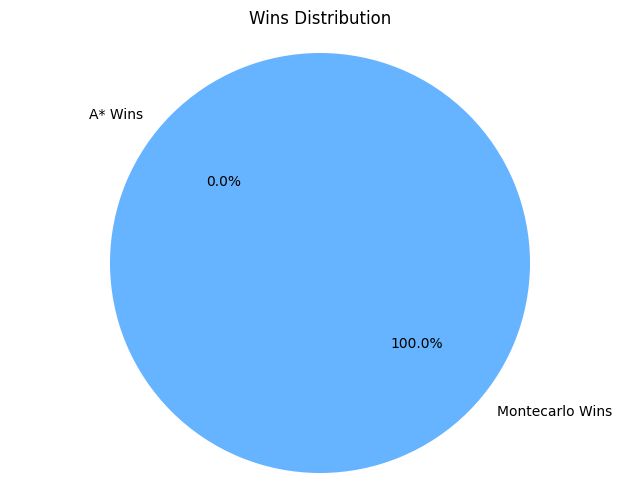

In [17]:
a_star_wins = 0
montecarlo_wins = 0

for i in range(5):
    game_board = Board()  
    bot_astar_h2 = AStarBot_h2(game_board, 1)
    bot_montecarlo = MonteCarlo(game_board, 2)

    first_player = random.choice([1, 2])

    random_column = random.randint(0, game_board.cols)
    game_board.move(random_column, first_player)


    while not game_board.end:
        if game_board.turn == 1:
            bot_astar_h2.play()
        else:
            bot_montecarlo.play()

    
    if game_board.winner == 'X':
        a_star_wins += 1
    elif game_board.winner == 'O':
        montecarlo_wins += 1

    print(f"Game {i+1}:")
    print(game_board)
    print("Winner:", game_board.winner)

print("Total wins for A*: ", a_star_wins)
print("Total wins for Montecarlo: ", montecarlo_wins)


import matplotlib.pyplot as plt

labels = ['A* Wins', 'Montecarlo Wins']
values = [a_star_wins, montecarlo_wins]
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Wins Distribution')
plt.axis('equal') 
plt.show()


**2. A STAR (HEURISTIC 2) VS MINIMAX**

A* is an informed but non-adversial strategy algorithm and Minimax is a decision-making algorithm (used in two-player games). 

They are both based on the 2nd heuristic function (explained above), but they are applied in different contexts and operate differently.

A* uses the heuristic function to estimate the cost of reaching the goal from a given state and combines this with actual path cost to make decisions about which path to explore next. It aims to minimize the total cost, which is the sum of the heuristic estimate and the actual cost of reaching the current state (1 for this game). Its primary purpose is finding the shortest path from a start state to a goal state in a search space.

On the other hand, Minimax is using the same heuristic function to evaluate each game state. The basic idea is to minimize the maximum possible loss by considering all possible moves and their outcomes, up to a certain depth.


Concluding, Minimax has a better performance than A* in the decision-making for the Connect-Four game.

Game 1:
.......
.......
.......
.......
.X.....
.OOOO.X

Winner: O
Game 2:
.......
.......
...O...
...O...
...O..O
XXXO.XX

Winner: O
Game 3:
.......
.......
......X
......O
..X...X
XOOOO.X

Winner: O
Game 4:
.......
.......
.......
.......
...O.X.
XXOOOO.

Winner: O
Game 5:
.......
.......
..O....
..O....
..O....
XXO....

Winner: O
Total wins for A*:  0
Total wins for Minimax:  5


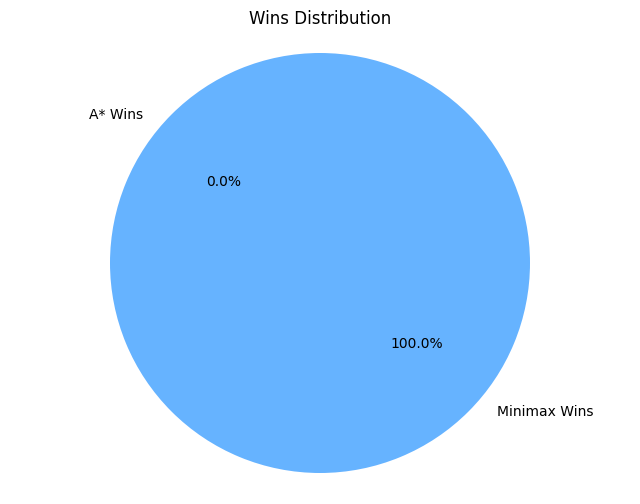

In [18]:
a_star_wins = 0
minimax_wins = 0

for i in range(5):
    game_board = Board() 
    bot_astar_h2 = AStarBot_h2(game_board, 1)
    bot_minimax = MinimaxBot(game_board, 2)

    first_player = random.choice([1, 2])

    random_column = random.randint(0, game_board.cols)
    game_board.move(random_column, first_player)


    while not game_board.end:
        if game_board.turn == 1:
            bot_astar_h2.play()
        else:
            bot_minimax.play()

    if game_board.winner == 'X':
        a_star_wins += 1
    elif game_board.winner == 'O':
        minimax_wins += 1

    print(f"Game {i+1}:")
    print(game_board)
    print("Winner:", game_board.winner)

print("Total wins for A*: ", a_star_wins)
print("Total wins for Minimax: ", minimax_wins)



import matplotlib.pyplot as plt

labels = ['A* Wins', 'Minimax Wins']
values = [a_star_wins, minimax_wins]

colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Wins Distribution')
plt.axis('equal')
plt.show()



**3. MONTECARLO VS MINIMAX**

Both MonteCarlo and Minimax are suitable algorithms for Connect-Four, on the other hand they have their strenghts and challenges.

One of minimax strengths is it systematically explores the entire game tree to find the optimal move, assuming perfect play from both players. On the other hand, it faces many challenges such as the fact that Connect Four has a relatively large branching factor, especially in the early game when many columns are available for play. This can make Minimax computationally expensive, especially for deeper search depths.

Monte Carlo Tree Search (MCTS) is well-suited for games with complex branching factors and imperfect information, making it a good candidate for Connect Four. It uses random simulations to guide its search through the game tree, focusing computational effort on promising areas. MCTS does not require heuristics for non-terminal game states, making it easier to implement and potentially more adaptable to different game states. Regardless of that MCTS is not perfect, it typically requires a larger number of simulations to converge to strong move recommendations compared to Minimax. However, even with fewer simulations, it can still provide reasonable move recommendations. The quality of MCTS recommendations can vary depending on the number of simulations performed, and it may not always find the optimal move within a limited number of iterations.

In summary, Minimax offers a systematic approach to exploring the game tree but can be computationally expensive, especially in games with large branching factors. On the other hand, MCTS provides a more flexible and adaptable approach, particularly suitable for games with complex branching factors and imperfect information like Connect Four. The choice between them depends on factors such as computational resources, desired level of performance, and the specific characteristics of the game environment.

Game 1:
.......
..X....
..XO...
..XOO..
..OOX..
..OOX..

Winner: O
Game 2:
.XXOX.O
.OOOXOX
.OXXXOX
OXOXOXX
OXOXOXO
OXXOOOX

Winner: O
Game 3:
.X.O...
OO.OOO.
OO.XOX.
XXOOXO.
XXXOXO.
XXXOXO.

Winner: O
Total wins for Montecarlo:  0
Total wins for Minimax:  3


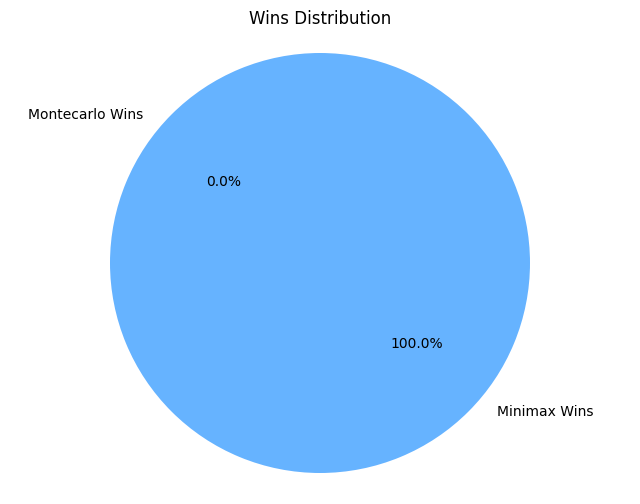

In [19]:
montecarlo_wins = 0
minimax_wins = 0

for i in range(5):
    game_board = Board() 
    bot_montecarlo = MonteCarlo(game_board, 1)
    bot_minimax = MinimaxBot(game_board, 2)

    first_player = random.choice([1, 2])

    random_column = random.randint(0, game_board.cols-1)
    game_board.move(random_column, first_player)


    while not game_board.end:
        if game_board.turn == 1:
            bot_montecarlo.play()
        else:
            bot_minimax.play()

    if game_board.winner == 'X':
        montecarlo_wins += 1
    elif game_board.winner == 'O':
        minimax_wins += 1

    print(f"Game {i+1}:")
    print(game_board)
    print("Winner:", game_board.winner)

print("Total wins for Montecarlo: ", montecarlo_wins)
print("Total wins for Minimax: ", minimax_wins)


import matplotlib.pyplot as plt

labels = ['Montecarlo Wins', 'Minimax Wins']
values = [montecarlo_wins, minimax_wins]
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Wins Distribution')
plt.axis('equal')  
plt.show()


**4. MINIMAX VS ALPHABETA**

Minimax and Alphabeta are both decision-making algorithms and operate similarly, with some differences:

Minimax explores the entire game tree by recursively considering all possible moves and their outcomes up to a certain depth.
It evaluates each resulting game state using a heuristic evaluation function and chooses the move that leads to the most favorable outcome for the player, assuming optimal play from both players. It can be computationally expensive because it needs to evaluate every node in the game tree.

Alphabeta uses the alphabeta prunning technique, an optimization technique applied to Minimax to reduce the number of nodes it has to evaluate. If maintained the Minimax depth, Alphabeta will save time and memory. If maintained the time and memory of Minimax for a certain depth, Alphabeta is capable of seraching deeper into the game tree. 

Concluding, as we increased depth from 5 (Minimax depth) to 7, the Alphabeta's performance outcomes Minimax's, specially because it goes further in the game tree and makes a more informed decision. It kept the same depth, Alphabeta takes less time and saves memory.

Game 1:
.......
.......
...O...
...O...
...O...
X..OXXX

Winner: O
Game 2:
.......
.......
.......
.......
OOOO...
XXXO.XX

Winner: O
Game 3:
.......
.......
.......
.......
OOOO...
XXXO.XX

Winner: O
Total wins for Minimax:  0
Total wins for Alphabeta:  3


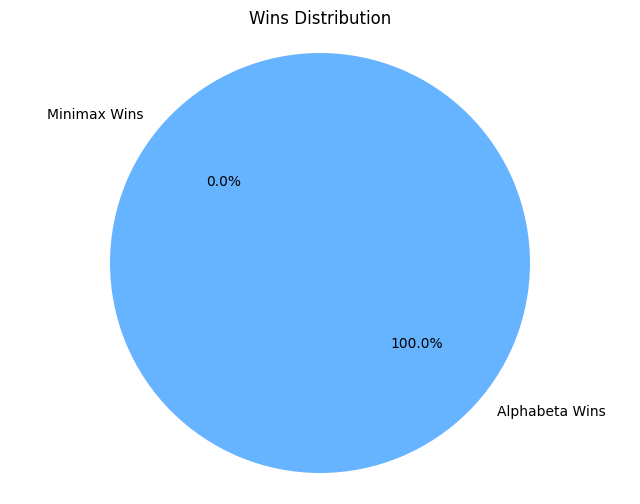

In [20]:
minimax_wins = 0
alphabeta_wins = 0

for i in range(5):
    game_board = Board() 
    bot_minimax = MinimaxBot(game_board, 1)
    bot_alphabeta = AlphaBetaBot(game_board, 2)
    

    first_player = random.choice([1, 2])

    random_column = random.randint(0, game_board.cols-1)
    game_board.move(random_column, first_player)


    while not game_board.end:
        if game_board.turn == 1:
            bot_minimax.play()
        else:
            bot_alphabeta.play()


    if game_board.winner == 'X':
        minimax_wins += 1
    elif game_board.winner == 'O':
        alphabeta_wins += 1

    print(f"Game {i+1}:")
    print(game_board)
    print("Winner:", game_board.winner)

print("Total wins for Minimax: ", minimax_wins)
print("Total wins for Alphabeta: ", alphabeta_wins)


import matplotlib.pyplot as plt

labels = ['Minimax Wins', 'Alphabeta Wins']
values = [minimax_wins, alphabeta_wins]
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Wins Distribution')
plt.axis('equal')  
plt.show()

## **Final Conclusion** ##

During this project, we received as the problem to solve an 2-player game Connect-4. Therefore, we focused our work on 2 major types of problem-solving AI strategies : informed strategies (A*) and adversial strategies (Montecarlo, Minimax and Alphabeta). 

Informed strategies, such as A*, leverage heuristic information to go through the search space towards a goal state. While effective in certain problem domains, their nature and lack of consideration for opponent actions can limit their performance in adversarial cenarios like Connect-4, where opponents actively interfere with each other's goals.

On the other hand, adversial strategies, such as Montecarlo, Minimax and Alphabeta, are made for decision-making in competitive cenarios, exactly like Connect-4. As they are capable to take into account opponent moves and their outcomes, the aim to maximize the player's advantage while minimizing potential losses. 


In our experimentation, we confirmed that while informed strategies provided efficient solutions in scenarios with well-defined objectives and search spaces, adversarial strategies demonstrated superior performance in the dynamic and interactive environment of Connect-4. 
